In [1]:
#导入必要的库
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.optimizers import Nadam

# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
# 设置随机种子
np.random.seed(1234)

# tensorflow V2.x
# For Tensorflow 2.0 tf.random.set_random_seed(seed) changed to tf.random.set_seed(seed).
tf.random.set_seed(1234)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import csv
import os
directory='/content/drive/My Drive/taidi//'
filename='month_sum.csv'
filepath=os.path.join(directory,filename)

In [5]:
# 读取数据
# df = pd.read_csv('./全部数据/order_train1.csv',parse_dates=["order_date"],index_col=[0])   # 把日期变为索引
# df = pd.read_csv('./全部数据/month_sum.csv')   
df = pd.read_csv(filepath)   # 读取存在google drive的文件


# df = df.drop(columns = ['sales_chan_name','item_price'])  # 先删除price列，因为predict_sku0没有price特征，后面可看看利用price

first_col = df.pop('ord_qty')
df.insert(1, 'ord_qty', first_col)  #把订单量变为第一列

display(df)  
df.info()

,order_date,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,item_price,brand_qty_median,brand_qty_average,rmean_1_1
0,2015/9/1,3091,20007,101,305,412,2015,9,99.384615,28,84.39,0
1,2015/9/1,308,20008,101,303,401,2015,9,657.000000,22,56.08,0
2,2015/9/1,260,20009,101,306,407,2015,9,672.000000,36,112.20,0
3,2015/9/1,19,20019,101,302,408,2015,9,1195.000000,24,66.75,0
4,2015/9/1,265,20020,101,305,412,2015,9,1909.428571,28,84.39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56155,2018/12/1,7224,22066,105,307,403,2018,12,330.666667,41,112.68,10535
56156,2018/12/1,488,22072,105,305,412,2018,12,409.600000,28,84.39,1842
56157,2018/12/1,16,22080,105,306,407,2018,12,504.000000,36,112.20,8
56158,2018/12/1,7,22081,105,303,401,2018,12,2569.000000,22,56.08,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56160 entries, 0 to 56159
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_date         56160 non-null  object 
 1   ord_qty            56160 non-null  int64  
 2   item_code          56160 non-null  int64  
 3   sales_region_code  56160 non-null  int64  
 4   first_cate_code    56160 non-null  int64  
 5   second_cate_code   56160 non-null  int64  
 6   year               56160 non-null  int64  
 7   month              56160 non-null  int64  
 8   item_price         56160 non-null  float64
 9   brand_qty_median   56160 non-null  int64  
 10  brand_qty_average  56160 non-null  float64
 11  rmean_1_1          56160 non-null  int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 5.1+ MB


In [6]:
testset_start = df[(df.year==2018)&(df.month==9)].index.tolist()[0]
testset_end = df[(df.year==2018)&(df.month==11)].index.tolist()[-1]
print(testset_start, testset_end)

48594 54363


In [7]:
#设置LSTM的时间窗等参数
window = 60  # 30 3 240
lstm_units = 200  # 100 200
dropout = 0.01  
epoch=50  # 最大epoch, 会早停
batch_size = 480  # 128 256 480
activation='tanh'

In [8]:
# #进行数据归一化
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# df0=min_max_scaler.fit_transform(df1)
# df = pd.DataFrame(df0, columns=df1.columns)
# input_size=len(df.iloc[1,:])  # 特征数量

In [9]:
# 拆分训练/验证集, 验证集为2018.9 - 2018.11数据， 训练集为验证集之前的数据
# X_train = df.iloc[0:testset_start-1,2:].values
# Y_train = df.iloc[0:testset_start-1,0].values
# X_test = df.iloc[testset_start:testset_end,2:].values
# Y_test = df.iloc[testset_start:testset_end,0].values
# # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False, random_state=33)  # 暂不打乱数据集
# input_size= X_train.shape[1]  # 特征数量

df_for_training=df.iloc[0:testset_start-1,1:]
df_for_testing=df.iloc[testset_start:testset_end,1:]
input_size= df_for_training.shape[1]  # 特征数量


In [10]:
print(df_for_training.shape)
print(df_for_testing.shape)
print(input_size)

(48593, 11)
(5769, 11)
11


In [11]:
display(df_for_training)
display(df_for_testing)

,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,item_price,brand_qty_median,brand_qty_average,rmean_1_1
0,3091,20007,101,305,412,2015,9,99.384615,28,84.39,0
1,308,20008,101,303,401,2015,9,657.000000,22,56.08,0
2,260,20009,101,306,407,2015,9,672.000000,36,112.20,0
3,19,20019,101,302,408,2015,9,1195.000000,24,66.75,0
4,265,20020,101,305,412,2015,9,1909.428571,28,84.39,0
...,...,...,...,...,...,...,...,...,...,...,...
48588,3,22061,105,306,407,2018,8,2159.000000,36,112.20,13
48589,6868,22066,105,307,403,2018,8,328.812500,41,112.68,2060
48590,8,22080,105,306,407,2018,8,493.000000,36,112.20,13
48591,26,22081,105,303,401,2018,8,2560.666667,22,56.08,35


,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,item_price,brand_qty_median,brand_qty_average,rmean_1_1
48594,45,20002,101,303,406,2018,9,2201.400000,22,56.08,31
48595,93,20003,101,301,405,2018,9,672.500000,28,73.96,164
48596,109,20006,101,307,403,2018,9,589.625000,41,112.68,150
48597,16,20014,101,307,403,2018,9,376.000000,41,112.68,2
48598,930,20016,101,303,401,2018,9,918.466667,22,56.08,758
...,...,...,...,...,...,...,...,...,...,...,...
54358,410,22058,105,302,408,2018,11,1411.421053,24,66.75,1628
54359,37,22059,105,305,412,2018,11,288.000000,28,84.39,33
54360,10535,22066,105,307,403,2018,11,340.187500,41,112.68,5557
54361,1842,22072,105,305,412,2018,11,412.200000,28,84.39,1082


In [12]:
# # 拆分训练/测试集
# train_size = int(len(df) * 0.9)
# # test_size = len(df) - train_size
# df_for_training=df[0:train_size]
# df_for_testing=df[train_size:len(df)]

# input_size=len(df.iloc[1,:])  # 特征数量

# print(df_for_training.shape)
# print(df_for_testing.shape)

In [13]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 数据标准化
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)

In [14]:
# 分X,Y
def createXY(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-window-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+window), 0:dataset.shape[1]]   
		dataX.append(a)
		dataY.append(dataset[i + window, 0]) #第一列为订单量
	return np.array(dataX), np.array(dataY)

time_step = window
trainX,trainY=createXY(df_for_training_scaled,window)
testX,testY=createXY(df_for_testing_scaled,window)

In [15]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
print(trainX.shape[2])

(48532, 60, 11)
(48532,)
(5708, 60, 11)
(5708,)
11


In [16]:
# model = Sequential()

# # 第一层LSTM，12是单元个数超参数，多层LSTM前面几层必须return_sequences=True，输入20时间步，10个特征

# model.add(Bidirectional(LSTM(12, return_sequences=True), input_shape=(20, 10)))

# model.add(Dropout(0.1))

# # 最后一层LSTM,return_sequences=False

# model.add(Bidirectional(LSTM(12, return_sequences=False)))

# model.add(Dropout(0.1))

# # 重点是这里的5*3的设置

# model.add(Dense(5 * 3))

# model.add(Dropout(0.1))

# # 输出5个时间步长，3个特征

# model.add(Reshape((5, 3)))

In [17]:
#建立LSTM模型 训练

# 优化器
my_adam = Adam(learning_rate=0.001)
my_nadam = Nadam(learning_rate = 0.001)


inputs=Input(shape=(window, input_size))
# model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
# model=MaxPooling1D(pool_size = window)(model)#池化层
# model=Dropout(dropout)(model)#droupout层
# 第一层LSTM，12是单元个数超参数，多层LSTM前面几层必须return_sequences=True，输入window个时间步，input_size个特征
model=Bidirectional(LSTM(lstm_units, activation=activation, return_sequences=True), name='bilstm')(inputs)#双向LSTM层
model=Dropout(dropout)(model)#droupout层
# 最后一层LSTM,return_sequences=False
model=Bidirectional(LSTM(lstm_units, activation=activation, return_sequences=False),name='bilstm2')(model)
model=Dropout(dropout)(model)#droupout层
# attention=Dense(lstm_units, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
# model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer=my_nadam)

model.summary()


# model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
# model.compile(loss='mse',optimizer=my_nadam)
# my_model.summary()#展示模型结构

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 11)]          0         
                                                                 
 bilstm (Bidirectional)      (None, 60, 400)           339200    
                                                                 
 dropout (Dropout)           (None, 60, 400)           0         
                                                                 
 bilstm2 (Bidirectional)     (None, 400)               961600    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 1,301,201
Trainable params: 1,301,201
Non-train

In [18]:
# use early stop to avoid over-fiting  早停法防止过拟合,若loss不减小，训练停止
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

# 模型训练
history=model.fit(trainX, trainY, epochs = epoch, batch_size = batch_size, shuffle=False,callbacks=[monitor], validation_data=(testX, testY)) #训练模型epoch次

Epoch 1/50
102/102 [==============================] - 23s 119ms/step - loss: 0.0100 - val_loss: 0.0016
Epoch 2/50
102/102 [==============================] - 11s 105ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/50
102/102 [==============================] - 11s 106ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/50
102/102 [==============================] - 11s 107ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/50
102/102 [==============================] - 11s 112ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/50
102/102 [==============================] - 11s 110ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/50
102/102 [==============================] - 11s 107ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/50
102/102 [==============================] - 11s 110ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/50
102/102 [==============================] - 11s 112ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/50
102/102 [==============================] - 12s 115ms/step - l

In [19]:
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV
# # grid_model=KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
# grid_model=KerasRegressor(build_fn=my_model,verbose=1,validation_data=(testX,testY))
# parameters = {'batch_size' : [128,576],
#         'epochs' : [25],
#         # 'optimizer' : ['adam'] 
#         'dropout': [0.002],
#         'optimizer' : [my_nadam],
#         'lstm_units': [50, 100, 200],
#         'activation': ['tanh','relu'] }

# grid_search  = GridSearchCV(estimator = grid_model,
#                 param_grid = parameters, n_jobs=-1,
#                 cv = 2)

In [20]:
# # # use early stop to avoid over-fiting  早停法防止过拟合,若loss不减小，训练停止
# # from tensorflow.keras.callbacks import EarlyStopping
# # monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, 
# #         verbose=1, mode='auto', restore_best_weights=True)

# # grid_search = grid_search.fit(trainX,trainY, epochs = epoch, callbacks=[monitor])
# grid_search = grid_search.fit(trainX,trainY )


In [21]:
# grid_search.best_params_

In [22]:
# model = grid_search.best_estimator_.model
# model.summary()  # 展示模型结构

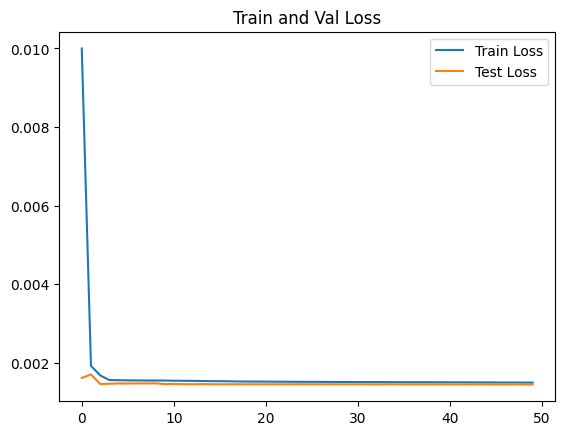

In [23]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
# loss = model.history['loss']
# val_loss = model.history['val_loss']
# epochs_range = range(epoch)
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

179/179 [==============================] - 2s 7ms/step
(5708, 1)


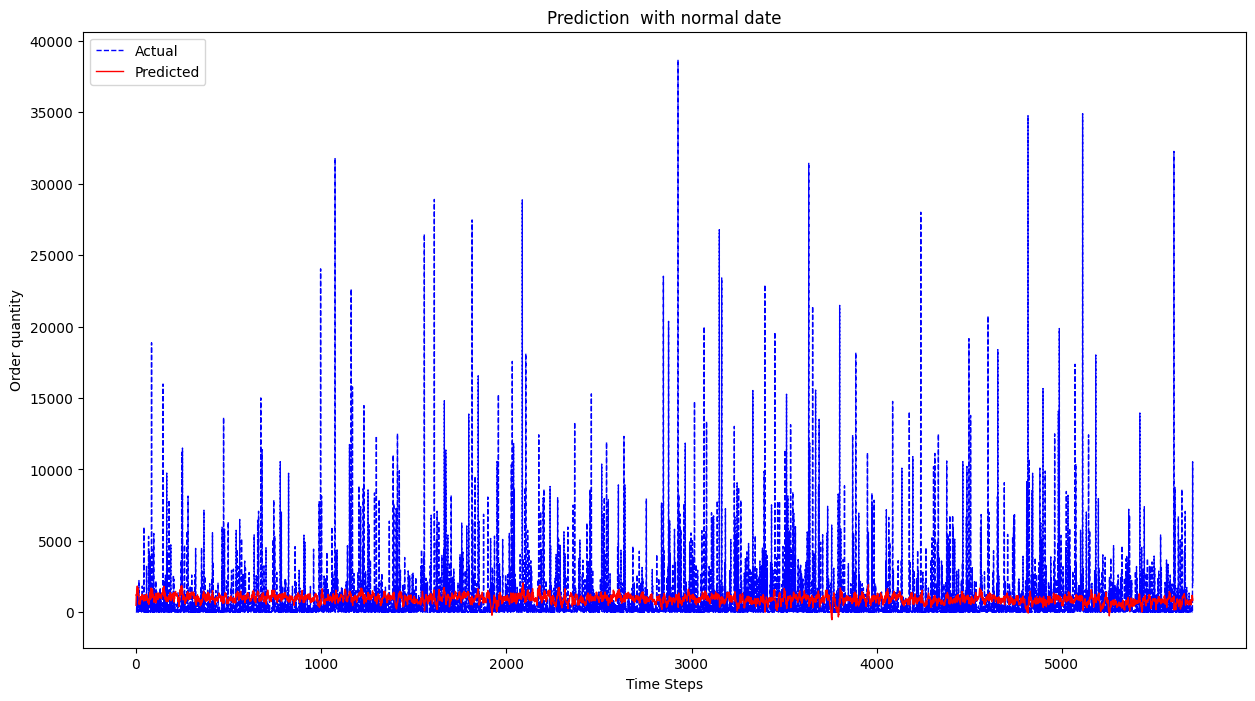

In [24]:
# 还原模型预测

# create the list of difference between prediction and test data
predictions = model.predict(testX)
print(predictions.shape)

# 反归一化
prediction_copies_array = np.repeat(predictions,testX.shape[2], axis=-1)
predictions_inv=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),testX.shape[2])))[:,0]

testY_copies_array = np.repeat(testY,testX.shape[2], axis=-1)
testY_inv=scaler.inverse_transform(np.reshape(testY_copies_array,(len(testY),testX.shape[2])))[:,0]


# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

axs.plot(testY_inv,color='blue', label='Actual',linestyle='--',linewidth=1)
axs.plot(predictions_inv,color='red', label='Predicted',linewidth=1)
# axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.title('Prediction  with normal date')
plt.xlabel('Time Steps')
plt.ylabel('Order quantity')
plt.legend(loc='upper left')
plt.show()


In [25]:
# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
print('------------验证集-------------')
print("mae:", mean_absolute_error(testY_inv, predictions_inv))
print("mape:", mean_absolute_percentage_error(testY_inv, predictions_inv))
print("mse:", mean_squared_error(testY_inv, predictions_inv))
print("rmse:", sqrt(mean_squared_error(testY_inv, predictions_inv)))
print("r2:", r2_score(testY_inv, predictions_inv))

------------验证集-------------
mae: 1252.5348745965841
mape: 40.72918063485536
mse: 6780898.247353988
rmse: 2604.0157924547975
r2: 0.0012718484080109782
